# Pneumonia Classification on TPU

<hr />

### Introduction + Set-up

This tutorial will explain how to build an X-ray image classification model to predict whether an X-ray scan shows presence of pneumonia.

In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

2025-04-15 03:34:17.388157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744688057.424996   54131 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744688057.435778   54131 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744688057.456194   54131 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744688057.456227   54131 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744688057.456230   54131 computation_placer.cc:177] computation placer alr

Number of replicas: 1


We need a Google Cloud link to our data to load the data using a TPU. Below, we define key configuration parameters we'll use in this example. To run on TPU, this example must be on Colab with the TPU runtime selected.

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

<hr />

### Load the data

The Chest X-ray data we are using from <a href="https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5">Cell</a> divides the data into training and test files. Let's first load in the training TFRecords.

In [3]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

2025-04-15 03:35:18.832118: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Let's count how many healthy/normal chest X-rays we have and how many pneumonia chest X-rays we have:

In [4]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

2025-04-15 03:35:38.649363: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-04-15 03:35:38.743234: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".
2025-04-15 03:35:40.086889: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Normal images count in training set: 1349
Pneumonia images count in training set: 3883


2025-04-15 03:35:41.487640: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Notice that there are way more images that are classified as pneumonia than normal. This shows that we have an imbalance in our data. We will correct for this imbalance later on in our notebook.

We want to map each filename to the corresponding (image, label) pair. The following methods will help us do that.

As we only have two labels, we will encode the label so that 1 or True indicates pneumonia and 0 or False indicates normal.

In [5]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    if parts[-2] == "PNEUMONIA":
        return 1
    else:
        return 0


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

Let's split the data into a training and validation datasets.

In [6]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

Let's visualize the shape of an (image, label) pair.

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

2025-04-18 03:16:38.112435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 236 of 10000
2025-04-18 03:16:57.022679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 776 of 10000
2025-04-18 03:17:15.934902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1202 of 10000
2025-04-18 03:17:38.954474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 4141 of 10000


Image shape:  (180, 180, 3)
Label:  1


2025-04-18 03:17:41.116366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


Load and format the test data as well.

In [8]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

<hr />

### Visualize the dataset

First, let's use buffered prefetching so we can yield data from disk without having I/O become blocking.

Please note that large image datasets should not be cached in memory. We do it here because the dataset is not very large and we want to train on TPU.

In [9]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Call the next batch iteration of the training data.

In [10]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

2025-04-18 03:17:53.272472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 236 of 10000
2025-04-18 03:18:12.520025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 776 of 10000
2025-04-18 03:18:23.172356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 990 of 10000
2025-04-18 03:18:34.649618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1307 of 10000
2025-04-18 03:18:51.387221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 4141 of 10000
2025-04-18 03:18:53.133103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-04-18 03:18:53.135398: W tensorflo

Define the method to show the images in the batch.

In [11]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

As the method takes in NumPy arrays as its parameters, call the numpy function on the batches to return the tensor in NumPy array form.

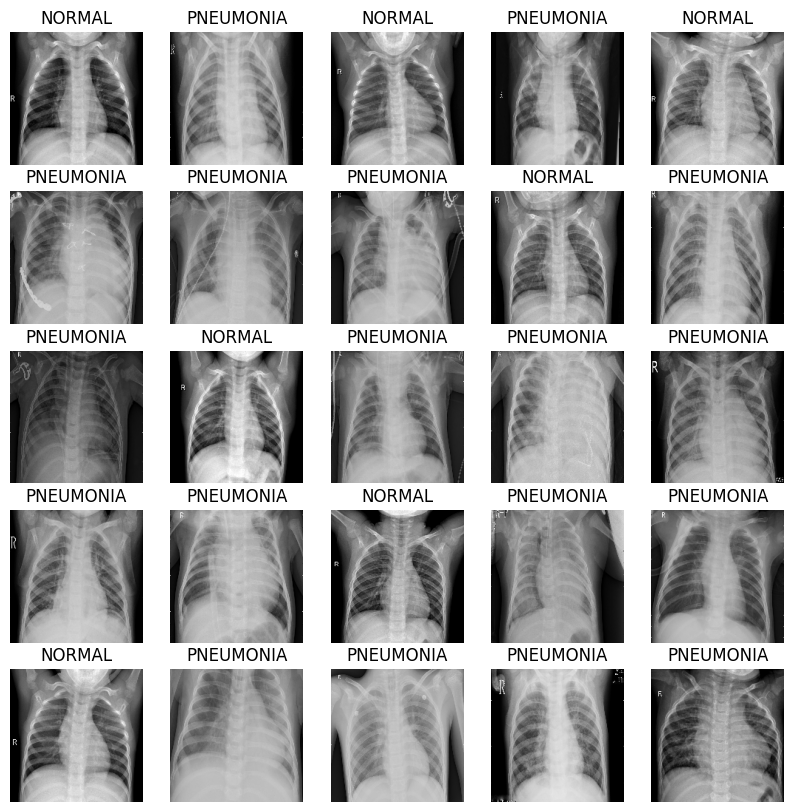

In [12]:
show_batch(image_batch.numpy(), label_batch.numpy())

<hr />

### Build the CNN

To make our model more modular and easier to understand, let's define some blocks. As we're building a convolution neural network, we'll create a convolution block and a dense layer block.

The architecture for this CNN has been inspired by this <a href="https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8">article</a>.

In [13]:
import os 
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras import layers

def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs